Objective:
Develop a machine learning model that predicts write energy for a PCM cell based on data patterns and
resistance states.

Methodology:
 Generate synthetic write patterns with varying data density (all-0s, all-1s, mixed).
 Assign energy values based on write transitions (e.g., 0→1 is more costly).
 Train a regression model (Linear Regression or XGBoost) to estimate write energy.

Deliverables:
 Write energy prediction tool
 Error metrics (MAE, RMSE) and result visualizations
 Basic report or poster

Complete by next week:
  Step 1: Study energy characteristics of PCM write operations. Focus on how data transitions (0→1,
  1→0) and resistance states affect energy. Review past research that models write energy for emerging
  memory.

  Problem Formulation: 1. Define write energy estimation as a supervised regression task. 2. Inputs: bit
  pattern transitions, resistance states. 3. Output: predicted write energy (continuous value in nJ or pJ).


  Step 2: Data Design:
  Design Synthetic Data Patterns: Create 3 categories: All-0s, All-1s, Mixed patterns (random 0s and
  1s).
  
  For each pattern, define: Previous state, New state, Transition count: number of 0→1, 1→0, 0→0, and
  1→1 transitions.

  Assign Energy Values: Use known principles: 0→1: High energy (e.g., 1.2 units), 1→0: Medium
  energy (e.g., 0.8 units), No change: Low energy (~0.1 units)
  Total write energy = weighted sum based on number of transitions.

  Include Resistance State: 1. Simulate a resistance level per cell (e.g., float value between
  1KΩ–100KΩ). 2. Add resistance as a feature: higher resistance may correlate with more energy.
  Label Dataset: Each record includes: Pattern ID, resistance state, counts of transition types, total write energy (ground truth)

In [ ]:
import numpy as np
import pandas as pd
from pprint import pprint

#check in:
#what are the energy units in joules?

# Energy costs
ENERGY_COSTS = {
    "0to1": 1.2, #1.2 units
    "1to0": 0.8,
    "no_change": 0.1
    #0to 0 = 36pj
    #0-1 =
}

# Parameters
num_patterns = 50000 #num of examples
bit_length = 64 # change to 512 if want whole memory line

def generate_bit_pattern(category):
    """
    create bit patterns using bit length and numpy
    """
    if category == "all_zeros":
        return np.zeros(bit_length, dtype=int)
    elif category == "all_ones":
        return np.ones(bit_length, dtype=int)
    elif category == "mixed":
        return np.random.randint(0, 2, size=bit_length)

def count_transitions(prev, new):
    t_0to1 = np.sum((prev == 0) & (new == 1))
    t_1to0 = np.sum((prev == 1) & (new == 0))
    t_0to0 = np.sum((prev == 0) & (new == 0))
    t_1to1 = np.sum((prev == 1) & (new == 1))
    return t_0to1, t_1to0, t_0to0, t_1to1

def compute_write_energy(t_0to1, t_1to0, t_0to0, t_1to1):
    """
    for each transition calculate the energy cost
    """
    energy = (
        t_0to1 * ENERGY_COSTS["0to1"] +
        t_1to0 * ENERGY_COSTS["1to0"] +
        (t_0to0 + t_1to1) * ENERGY_COSTS["no_change"]
    )
    return energy

# Data collection
data = []

for i in range(num_patterns):
    category = np.random.choice(["all_zeros", "all_ones", "mixed"])
    new_category = np.random.choice(["all_zeros", "all_ones", "mixed"])
    prev_pattern = generate_bit_pattern(category)
    new_pattern = generate_bit_pattern(new_category)  # simulate write to random pattern

    # Count transitions
    t_0to1, t_1to0, t_0to0, t_1to1 = count_transitions(prev_pattern, new_pattern)

    # Simulate resistance between 1kΩ and 100kΩ
    resistance = np.random.uniform(1e3, 1e5)     #1 with 3 0s a d 1 and 5 0s

    # Compute write energy
    total_energy = compute_write_energy(t_0to1, t_1to0, t_0to0, t_1to1)

    # Add row
    data.append({
    "pattern_id": i,
    "prev_category": category,
    "new_category": new_category,
    "resistance": resistance,
    "total_energy": total_energy,
    "prev_bits": ''.join(map(str, prev_pattern)),
    "new_bits": ''.join(map(str, new_pattern)),
    "0_to_1": t_0to1,
    "1_to_0": t_1to0,
    "0_to_0": t_0to0,
    "1_to_1": t_1to1,

    })


# Create dataframe
df = pd.DataFrame(data)
#pprint(df.head)
display(df.iloc[4]) # Shows the row at index 42)
display(df.iloc[4]["new_bits"])

,4
pattern_id,4
prev_category,all_ones
new_category,mixed
resistance,6976.276809
total_energy,28.1
prev_bits,1111111111111111111111111111111111111111111111...
new_bits,0001011111010010110000110011110000011111111011...
0_to_1,0
1_to_0,31
0_to_0,0


'0001011111010010110000110011110000011111111011011110000010000011'

Step 3: Feature Engineering
Prepare Feature Vectors for Inputs and Output.
Normalize/Scale Features: Apply standard scaling (optional, especially for regression models like
Linear Regression).

## Collect data into tensors for our Linear NN:
Goal: predict energy based on features like previous pattern, new pattern, resistence, and specific bit transition counts

In [ ]:
int(df.iloc[4]["new_bits"], 2)

1716649070982717571

In [ ]:
import torch
input_features_categories = ["resistance", "prev_bits", "new_bits", "0_to_1", "1_to_0", "0_to_0", "1_to_1"]
#consider these after evalutation metrics
#include set and reset temp: which changes write capabilities, include bit write energy cost? or does ambient do this already, inlcude duration of the read write ratio how does this affect the data?
label_categories = ["total_energy"]
input_features = []
labels = []

for i in range(len(df)):
  sample_features = []
  for concept in input_features_categories:
    concept_data = df.iloc[i][concept]
    if type(concept_data) is str:
      concept_data = int(concept_data)
    sample_features.append(concept_data)

  input_features.append(sample_features)

  for concept in label_categories:
    concept_data = df.iloc[i][concept]
    labels.append(concept_data)

input_features = torch.DoubleTensor(input_features)
labels = torch.DoubleTensor(labels)


In [ ]:
print(input_features.shape) #shape: 1000 samples, 7 features
print(labels.shape) #shape: 1000 labels

torch.Size([50000, 7])
torch.Size([50000])


In [ ]:
print(input_features[0])

tensor([3.2704e+03, 1.0010e+60, 1.1111e+63, 3.3000e+01, 0.0000e+00, 0.0000e+00,
        3.1000e+01], dtype=torch.float64)


In [ ]:
print(labels[0])

tensor(42.7000, dtype=torch.float64)


# Create Linear NN model and XGBoost Model

## Dependencies for NN

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random

def set_random_seed(seed=5):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(5)
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


### Split Data Set

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

X= input_features.to(device)
y= labels.to(device)


#Normalize the inputs:
# Z-score normalization: (x - mean) / std


mean_x = torch.mean(X, dim=0, keepdim=True).to(device)
std_x = torch.std(X, dim=0, keepdim=True).to(device)
# Add small epsilon to avoid division by zero
std_x = torch.where(std_x == 0, torch.ones_like(std_x) * 1e-8, std_x).to(device)

normalized_X = ((X - mean_x) / std_x).to(device)

mean_y = torch.mean(y).to(device)
std_y = torch.std(y).to(device)
std_y = torch.where(std_y == 0, torch.ones_like(std_y) * 1e-8, std_y).to(device)
normalized_y = ((y - mean_y) / std_y).to(device)



# Convert to numpy for sklearn split, then back to tensors (ensure double precision)
X_np = normalized_X.detach().cpu().double().numpy()
y_np = normalized_y.detach().cpu().double().numpy()

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_np, y_np, test_size=0.3, random_state=5
)

# Second split: 15% valid, 15% test (from the 30% temp)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=5
)

# Convert back to tensors (ensure double precision)
X_train = torch.tensor(X_train, dtype=torch.float64)
y_train = torch.tensor(y_train, dtype=torch.float64)
X_valid = torch.tensor(X_valid, dtype=torch.float64)
y_valid = torch.tensor(y_valid, dtype=torch.float64)
X_test = torch.tensor(X_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders with shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




# Print dataset sizes
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(valid_loader)}")
print(f"Test batches: {len(test_loader)}")

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(valid_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

# Example of iterating through training data
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx}: data shape {data.shape}, target shape {target.shape}")
    if batch_idx == 2:  # Just show first 3 batches
        break

Training batches: 1094
Validation batches: 235
Test batches: 235
Training samples: 35000
Validation samples: 7500
Test samples: 7500
Batch 0: data shape torch.Size([32, 7]), target shape torch.Size([32])
Batch 1: data shape torch.Size([32, 7]), target shape torch.Size([32])
Batch 2: data shape torch.Size([32, 7]), target shape torch.Size([32])


## Neural Network:

### Define Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class NonLinearNN(nn.Module):
    def __init__(self, input_size=7, hidden_size=64, output_size=1):
        super(NonLinearNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [ ]:
print(f"mean_y: {mean_y.item():.4f}, std_y: {std_y.item():.4f}")

mean_y: 35.3157, std_y: 20.7833


### Training Loop

In [ ]:


model = NonLinearNN().double().to(device)
criterion = nn.MSELoss()
epochs=100
lr=0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs.squeeze(), batch_y.to(device))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    train_losses.append(total_loss)




    #Validation Set
    model.eval()
    val_total_loss = 0
    with torch.no_grad():
        for val_batch_X, val_batch_y in valid_loader:
            val_batch_X = val_batch_X.to(device)
            val_batch_y = val_batch_y.to(device)

            outputs = model(val_batch_X).squeeze()
            loss = criterion(outputs, val_batch_y)
            val_total_loss += loss.item()

    val_loss = val_total_loss / len(valid_loader)
    val_losses.append(val_loss)

    #Print Loss
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {avg_loss:.4f}, Validation Loss: {val_loss:.4f}')
      print()


Epoch [10/100], Training Loss: 0.0130, Validation Loss: 0.0136

Epoch [20/100], Training Loss: 0.0114, Validation Loss: 0.0111

Epoch [30/100], Training Loss: 0.0110, Validation Loss: 0.0125

Epoch [40/100], Training Loss: 0.0110, Validation Loss: 0.0110

Epoch [50/100], Training Loss: 0.0107, Validation Loss: 0.0100

Epoch [60/100], Training Loss: 0.0106, Validation Loss: 0.0067

Epoch [70/100], Training Loss: 0.0103, Validation Loss: 0.0039

Epoch [80/100], Training Loss: 0.0107, Validation Loss: 0.0115

Epoch [90/100], Training Loss: 0.0104, Validation Loss: 0.0040

Epoch [100/100], Training Loss: 0.0102, Validation Loss: 0.0108



### Test Set

In [ ]:
model.eval()  # Set model to eval mode
test_total_loss = 0
all_preds = []  # predicted outputs
all_targets = []  # true labels


with torch.no_grad():
    for test_batch_X, test_batch_y in test_loader:
        test_batch_X = test_batch_X.to(device)
        test_batch_y = test_batch_y.to(device)

        outputs = model(test_batch_X).squeeze()
        loss = criterion(outputs, test_batch_y)
        test_total_loss += loss.item()
        all_preds.append(outputs.cpu())
        all_targets.append(test_batch_y.cpu())

test_loss = test_total_loss / len(test_loader)
print(f'Average Test Loss: {test_loss:.4f}')
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()


Average Test Loss: 0.0105


### Evaluate Predictions

In [ ]:

# Show predictions
model.eval()
with torch.no_grad():
    predictions_normalized = model(normalized_X)

    print(f"Actual labels: {y[:15]} \n")
    predictions_denormalized = (predictions_normalized * std_y) + mean_y
    print(f"Sample predictions: {predictions_denormalized.squeeze()[:15]} \n")



Actual labels: tensor([42.7000, 35.8000, 39.4000, 50.4000, 28.1000, 40.6000, 76.8000, 47.1000,
        76.8000, 31.1000, 36.1000, 28.1000, 76.8000,  6.4000, 32.3000],
       device='cuda:0', dtype=torch.float64) 

Sample predictions: tensor([41.8258, 35.2063, 38.9237, 47.7193, 28.3389, 40.1372, 72.3183, 45.5751,
        72.3747, 31.2329, 36.1359, 28.3990, 72.3427,  9.3539, 31.7405],
       device='cuda:0', dtype=torch.float64) 



### Accuracy Metrics

In [ ]:
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, r2_score, accuracy_score

# For regression
mse = mean_squared_error(all_targets, all_preds)  # RMSE = sqrt(MSE)
rmse = mse ** 0.5
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

# # For classification (if applicable)
# # Convert continuous outputs to predicted classes first, e.g. via threshold or argmax
# pred_classes = (all_preds > 0.5).astype(int)  # example thresholding for binary
# f1 = f1_score(all_targets, pred_classes)
# accuracy = accuracy_score(all_targets, pred_classes)

# print(f"F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")


RMSE: 0.1023, MAE: 0.0742, R^2: 0.9894


## XGBoost

### XGBoost dependencies

In [ ]:
!pip install xgboost


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Ensure all tensors are detached from the computation graph and moved to CPU
X_train_np = X_train.detach().cpu().numpy()
y_train_np = y_train.detach().cpu().numpy()

X_valid_np = X_valid.detach().cpu().numpy()
y_valid_np = y_valid.detach().cpu().numpy()

X_test_np = X_test.detach().cpu().numpy()
y_test_np = y_test.detach().cpu().numpy()

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train_np, label=y_train_np)
dvalid = xgb.DMatrix(X_valid_np, label=y_valid_np)
dtest  = xgb.DMatrix(X_test_np,  label=y_test_np)


### Define Model

In [ ]:

params = {
    'objective': 'reg:squarederror',  # regression task
    'eval_metric': 'rmse',             # evaluation metric
    'max_depth': 6,
    'eta': 0.1,                       # learning rate
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 5
}
num_round = 100
bst = xgb.train(params, dtrain, num_boost_round=num_round, evals=[(dtest, 'eval'), (dvalid, 'validation')], early_stopping_rounds=10, verbose_eval=10)
preds = bst.predict(dtest)


[0]	eval-rmse:0.89678	validation-rmse:0.91228
[10]	eval-rmse:0.31938	validation-rmse:0.32471
[20]	eval-rmse:0.11622	validation-rmse:0.11844
[30]	eval-rmse:0.04624	validation-rmse:0.04738
[40]	eval-rmse:0.02170	validation-rmse:0.02172
[50]	eval-rmse:0.01376	validation-rmse:0.01284
[60]	eval-rmse:0.01097	validation-rmse:0.00890
[70]	eval-rmse:0.00982	validation-rmse:0.00730
[80]	eval-rmse:0.00918	validation-rmse:0.00635
[90]	eval-rmse:0.00875	validation-rmse:0.00565
[99]	eval-rmse:0.00847	validation-rmse:0.00523


### Evaluate XGBoost

In [ ]:
std_y_np = std_y.detach().cpu().numpy()
mean_y_np =  mean_y.detach().cpu().numpy()
y_denormalized = (y_test_np * std_y_np) + mean_y_np
preds_denormalized = (preds * std_y_np) + mean_y_np

print(f"Actual labels: {y_denormalized[:15]} \n")
print(f"Sample predictions: {preds_denormalized[:15]} \n")

Actual labels: [ 6.4  6.4 27.4  6.4  6.4  6.4 76.8 41.1  6.4 76.8  6.4 37.5 29.5  6.4
 33.3] 

Sample predictions: [ 6.40010737  6.40247839 27.40186395  6.40247839  6.40010737  6.40247839
 76.79557217 40.7338034   6.40247839 76.79557217  6.40010737 37.26915944
 29.50473786  6.40010737 33.28894151] 



### Accuracy Metrics

In [ ]:
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, r2_score, accuracy_score

# For regression
mse = mean_squared_error(y_test, preds)  # RMSE = sqrt(MSE)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")


RMSE: 0.0085, MAE: 0.0016, R^2: 0.9999


# Comparison

After 10,000 samples:

XGBoost: RMSE: 0.0068, MAE: 0.0021, R^2: 1.0000

Neural Network: RMSE: 0.0485, MAE: 0.0317, R^2: 0.9977

Create graphs, increase # of samples, keep results of 10,000 and then try the 50,000, apply real data

Figure 4: Predicted vs Actual Energy Scatter Plots
python
Copy
Edit


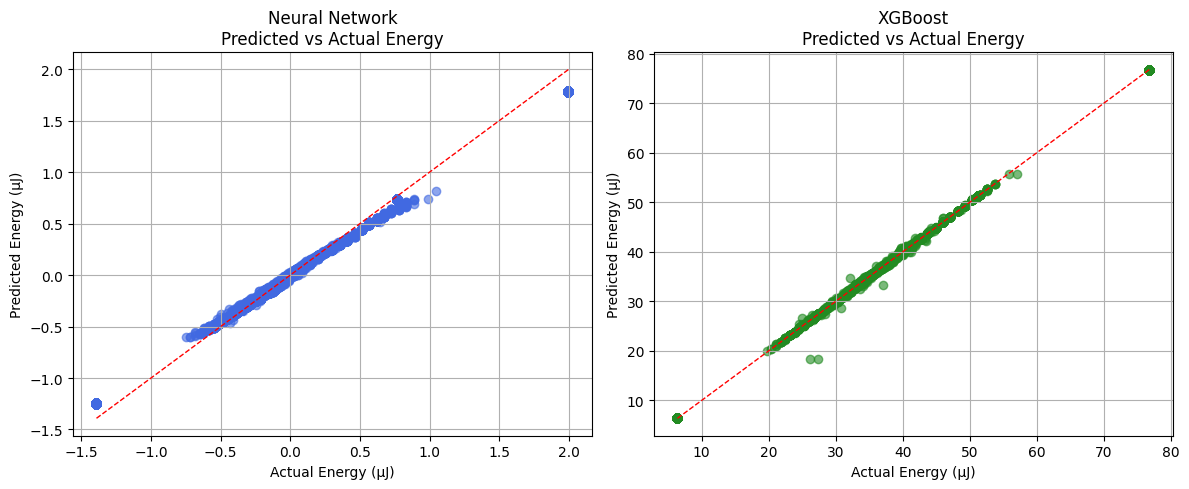

In [ ]:
import matplotlib.pyplot as plt

# --- For Neural Network ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(all_targets, all_preds, alpha=0.6, color='royalblue')
plt.plot([min(all_targets), max(all_targets)],
         [min(all_targets), max(all_targets)],
         color='red', linestyle='--', linewidth=1)
plt.title('Neural Network\nPredicted vs Actual Energy')
plt.xlabel('Actual Energy (μJ)')
plt.ylabel('Predicted Energy (μJ)')
plt.grid(True)

# --- For XGBoost ---
plt.subplot(1, 2, 2)
plt.scatter(y_denormalized, preds_denormalized, alpha=0.6, color='forestgreen')
plt.plot([min(y_denormalized), max(y_denormalized)],
         [min(y_denormalized), max(y_denormalized)],
         color='red', linestyle='--', linewidth=1)
plt.title('XGBoost\nPredicted vs Actual Energy')
plt.xlabel('Actual Energy (μJ)')
plt.ylabel('Predicted Energy (μJ)')
plt.grid(True)

plt.tight_layout()
plt.savefig("nn_xgb_scatter.png", dpi=300)
plt.show()


Figure 5: Neural Network Loss Curve
To track loss during training, you’ll need to store training and validation loss per epoch. Update your training loop first like this:

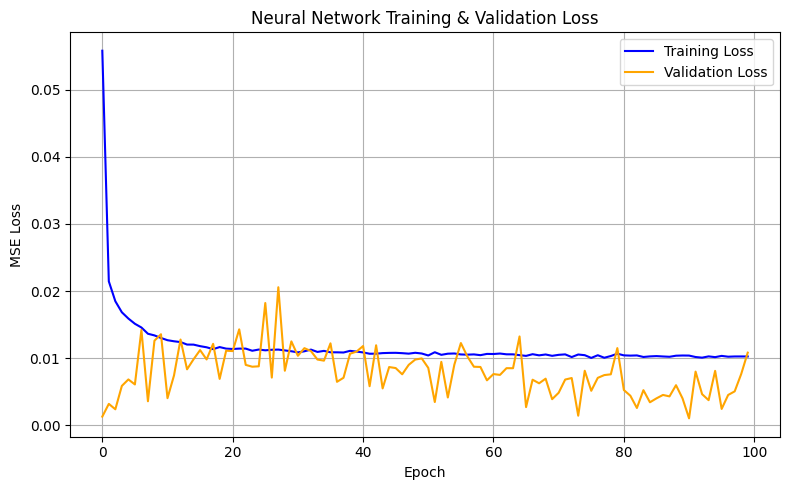

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Neural Network Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("nn_loss_curve.png", dpi=300)
plt.show()


## Saving and Loading the Model States:

In [ ]:
# import torch

# # Initialize your model
# model = NonLinearNN(input_size=7, hidden_size=64, output_size=1)

# # --- Save model state ---
# torch.save(model.state_dict(), 'nonlinear_nn_weights.pth')
# print("Model state saved to nonlinear_nn_weights.pth")


In [ ]:

# # --- Load model state ---
# # Make sure to create a new instance of the model with the same parameters
# model_loaded = NonLinearNN(input_size=7, hidden_size=64, output_size=1)
# model_loaded.load_state_dict(torch.load('nonlinear_nn_weights.pth'))
# model_loaded.eval()  # Set to eval mode if you're doing inference
# print("Model state loaded successfully")


In [ ]:
# import xgboost as xgb

# # --- Save the model ---
# bst.save_model('xgb_model.json')
# print("XGBoost model saved to xgb_model.json")



In [ ]:

# # --- Load the model ---
# bst_loaded = xgb.Booster()
# bst_loaded.load_model('xgb_model.json')
# print("XGBoost model loaded successfully")

# # Use loaded model to predict
# preds_loaded = bst_loaded.predict(dtest)